- create function
- randomly generate particle positions
- input sigma values to fulfill condition
- generate random vx, vz given by energy (10 kev and m), fulfull velocity condition
    - both conditions met, append 
- run through fodo lens, plot ellipse, should be rotating (future idea:  calculate area to make sure it isn't changing)


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:

def check_IC (mass, energy, sigma, n): #function to check position and velocity conditions
    sigma_x, sigma_vx, sigma_z, sigma_vz = sigma #unpack list of sigmas
    x_list =[] #initialize list of x positions to store if conditions are met
    vx_list = [] # initialize list of x velocities (x prime) to store if conditions are met
    
    while len(x_list) < n: #loop until the x and x velocity list have the desired number of particles that meet 
                                                                                #the initial conditions
        x = np.random.uniform(-1,1) #mm
        z = np.random.uniform(-10,10) #mm
        vx = np.random.uniform(-1,1) #mm/s
        vz = (2*energy*1.602e-19/mass)**(1/2) #mm/s
        
        position_cond = (sigma_x**2)/(x**2) + (sigma_z**2)/(z**2) #find value to check position condition
        vel_cond = (sigma_x**2)/(vx**2) + (sigma_z**2)/(vz**2) #find value to check velocity condition
        if position_cond >1 and vel_cond > 1: #check position and velocity condition
            x_list.append(x) #if both are met, append x and vx to lists
            vx_list.append(vx)
    return x_list, vx_list #return x and vx (x prime)

In [3]:
# Advance xv through element
def xv_adv(M,xv): 
    return( np.dot(M,xv) )


In [4]:
def step(initial_cond, n_advance, Lp):
    
    xv, s = initial_cond
    
    # Unit conversions
    mm = 1.e-3 # unit mm
    mr = 1.e-3 # unit mrad
    
    # Setup lattice elements
    M0 = np.array( [[1.,d],[0,1.]] )         # drift matrix
    MF = np.array( [[1.,0],[-1./f,1.]] )     # focus matrix
    MD = np.array( [[1.,0],[ 1./f,1.]] )     # defocus matrix

    # Initialize history "_h" arrays that will be used to plot x and x' evolution
    x_history  = [xv[0]]
    xp_history = [xv[1]]
    s_history  = [s]

    for turn in range(n_advance):

        # First half-drift
        # --- advance coordinates
        xv = xv_adv(M0, xv)
        s += d
        # -- save history appending arrays
        x_history.append(xv[0])
        xp_history.append(xv[1])
        s_history.append(s)

        # Focus quadrupole
        # --- advance coordinates
        xv = xv_adv(MF, xv)
        # --- save history
        x_history.append(xv[0])
        xp_history.append(xv[1])
        s_history.append(s) #keep sizes the same, thin kick does not advance s

        # two half drifts between quadrupoles
        # --- advance coordinates
        xv = xv_adv(M0,xv)
        xv = xv_adv(M0,xv)
        s += 2.*d
        # --- save history
        x_history.append(xv[0])
        xp_history.append(xv[1])
        s_history.append(s)

        # Defocus quadrupole
        # --- advance coordinates
        xv = xv_adv(MD,xv)
        # --- save history
        x_history.append(xv[0])
        xp_history.append(xv[1])
        s_history.append(s)

        # Final Half drift
        # --- advance coordinates
        xv = xv_adv(M0, xv)
        s += d
        # --- save history
        x_history.append(xv[0])
        xp_history.append(xv[1])
        s_history.append(s)
        
    # Convert to arrays
    x_history  = np.array(x_history)
    xp_history = np.array(xp_history)
    s_history  = np.array(s_history)
        
    return (x_history/mm, xp_history, s_history/Lp)

In [5]:
def multiparticle(n_advance, Lp, x_list, vx_list):
    
    for p in range(len(x_list)): #loop for number of particles
        
        #randomizing initial conditions
        xv = np.array([x_list[p], vx_list[p]])
        initial_cond = [xv, 0]
        x, xp, Lps = step(initial_cond, n_advance, Lp)
        
        plt.figure(1, figsize = (12,4))
        plt.plot(Lps, x)
        plt.title("Phase Space Evolution through %g FODO Cells" %n_advance, fontsize=16)
        plt.xlabel("Axial Coordinate $s/L_p$ [Lattice Periods]", fontsize=12)
        plt.ylabel("Position, $x$ [mm]", fontsize=12)
        
        
        plt.figure(2, figsize = (12,4))
        plt.plot(Lps, xp)
        plt.title("Phase Space Evolution through %g FODO Cells" %n_advance, fontsize=16)
        plt.xlabel("Axial Coordinate $s/L_p$ [Lattice Periods]", fontsize=12)
        plt.ylabel("Angle, $x'$ [mrad]", fontsize=12)
        
        plt.figure(3, figsize = (12,4))
        plt.scatter(x, xp)
        plt.title("Angle, $x'$ [mrad] vs. Position, $x$ [mm]", fontsize=16)
        plt.xlabel("Position, $x$ [mm]", fontsize=12)
        plt.ylabel("Angle, $x'$ [mrad]", fontsize=12)

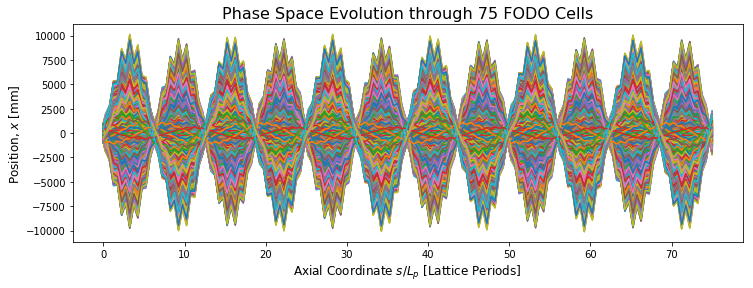

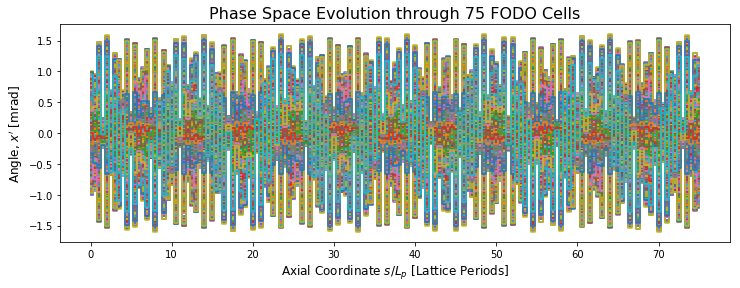

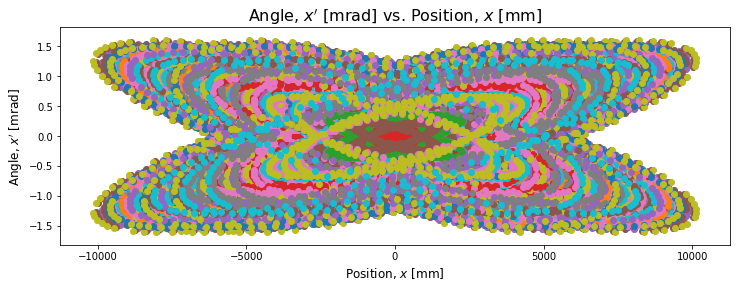

In [6]:
sigma_x = 0.1 #mm
sigma_vx = 1 #mm/s

sigma_z = 10 #mm
sigma_vz = 1 #mm/s

sigma = [sigma_x, sigma_vx, sigma_z, sigma_vz]

energy = 10e+3 #eV
mass = 3.952e-25 #kg

# Lattice parameters
d = 1.  # half drift length [m]
f = 4.      # focal length [m]
n_advance = 75 # lattice periods to advance
Lp = 4*d  # Lattice period [m]

x_list, vx_list = check_IC(mass, energy, sigma, 1000)
multiparticle(n_advance, Lp, x_list, vx_list)

In [7]:
x_list

[-0.8097130986556647,
 0.6749019661012232,
 -0.029840793228785856,
 0.20517588296903644,
 0.652653064503566,
 0.24078434462828935,
 0.6408323145337484,
 -0.8006317859268715,
 0.10044746291321904,
 -0.5773754007412493,
 0.8793761197845225,
 -0.6390281951972316,
 -0.44771497592045373,
 0.9835394604148311,
 -0.05596575918051516,
 -0.1328354398807683,
 -0.17162308145076222,
 -0.9040518987635584,
 0.04931481803482041,
 0.6498751696634022,
 -0.12401139050505505,
 0.8953413475235603,
 0.6950692288058382,
 0.9563281272092501,
 -0.7877554035517917,
 0.9885714711471332,
 -0.644623749581348,
 -0.8228015373657678,
 -0.918176532072027,
 0.6020461143883993,
 -0.8546074443564893,
 0.3675679930986775,
 -0.26133602266075373,
 -0.5719569043237931,
 0.6170508312033773,
 0.05977760775757157,
 -0.6076312377012374,
 0.2602428057504116,
 0.04815654158634408,
 0.5103611333421871,
 0.5821376181942455,
 -0.2868371412036732,
 -0.03175808106223266,
 -0.2254327664506508,
 -0.276847948344662,
 0.9861889697443167,
 

In [8]:
xp_list

NameError: name 'xp_list' is not defined

In [ ]:
sigma